## Summary

The following script retrieves data using the Youtube API. We will explore some basic metrics from a tech channel I'm currently subscribed to and do a bit of EDA on it's content. Unfortunately, dislikes have been disabled from public view so I will be focusing on content that is more popular. Sentiment analysis will be done on all the videos containg comments. The results should add an additional dimension to our EDA as far as evaluating content popularity is concerned aside from views and likes. Data will be stored in csv and db format after initial api processing for subsequent queries. The idea is to give creators a way to retrieve, store, and process content data efficiently. 

## Table of Contents
* [Imports & Constants](#Imports_&_Constants)
    * [Import Libs](#Import_Libs)
    * [Constants](#Constants)
* [Fetch Data](#Fetch_Data)
* [Video ID's](#Video_ID's)
* [Fetch Comments](#Fetch_Comments)
* [Comments Data Processing](#Comments_Data_Processing)
* [Fetch Video Stats](#Fetch_Video_Stats)
* [Putting The Data Together](#Putting_The_Data_Together)
* [EDA](#EDA)
    * [Scatter Plot](#Scatter_Plot)
    * [Distribution Plot](#Distribution_Plot)
    * [Pair Plot](#Pair_Plot)
    * [Linear Regression](#Linear_Regression)
    * [Top Ten Plot](#Top_Ten_Plot)
    * [Swarm Plot](#Swarm_Plot)
    * [Box Plot](#Box_Plot)
* [Conclusion](#Conclusion)

## Imports & Constants <a class="anchor" id="Imports_&_Constants"></a>

### Import Libs Import Libs <a class="anchor" id="Import_Libs"></a>

In [187]:
from googleapiclient.discovery import build
from pandas.api.types import CategoricalDtype
from textblob import TextBlob
import config
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import re
import missingno as msno
import string
from matplotlib import rc_context
from matplotlib import ticker as tick
import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline
import matplotlib.dates as mpl_dates
from scipy import stats
import datetime as dt
import time
from datetime import datetime
from datetime import date
sns.set(style="darkgrid")
import warnings
warnings.simplefilter("ignore")

### Constants <a class="anchor" id="Constants"></a>

The API_KEY that I have is saved in a separate file that does not get pushed to my repo for security. If you want to run this script you'll need to create your own key via googles developer console enter it below. The CHANNEL_ID is from a popular tech channel I watch, there are tutorials out there that will explain how to get a unique content creators channel id. The youtube variable creates an API client to use with your requests.

In [2]:
API_KEY = config.API_KEY
CHANNEL_ID = 'UC0WNX0de8I1fgKUrjxiPaRA'
youtube = build('youtube', 'v3', developerKey= API_KEY)

## Fetch Data <a class="anchor" id="Fetch_Data"></a>

The fetch_playlist_id() method is used to gather the playlist id for the channel which is needed in order to retrieve the video id's for each channel. The request variable enables the user to query the API. The playlist_id is what is necessary to access all the videos from the channel and has been returned a single string.

In [3]:
def fetch_playlist_id(CHANNEL_ID):
    
    """
    Function fetch_playlist_id makes a call to Youtube API.

    The API key is stored in a private config.py file for security reasons.
    Any user will need their on unique and API_KEY to run this method.

    Args:
        youtube (global): Allows your application to retrieve YouTube content .
        CHANNEL_ID (string): String unique to each youtube channel.
        
    Returns:
        A single string unique to each channels playlist id.
    """
    
    global youtube
   
    request = youtube.channels().list(
                part="snippet,contentDetails,statistics",
                id=CHANNEL_ID)
    response = request.execute()
   
    for i in range(len(response['items'])):
        data = dict(playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
    
    return data['playlist_id']

In [5]:
playlist_id = fetch_playlist_id(CHANNEL_ID)

## Video ID's <a class="anchor" id="Video_ID's"></a>

The api only allows for the retrieval of 50 results per request, but the entire list can be acquired using the nextPageToken. The initial query is written and excuted along with an empty list to store our unique id's in. If we have a look at the initial response as of today this channel has 1563 videos and the initial search gives 50 results. The nextPageToken key also holds a string value which we will need to save in order to construct the while loop so that we are able to run our search until all values have been saved to the video_id list. The initial request will acquire the first 50 results. While more_pages is true the api query will execute and gather the id's 50 per request and append them until the next_page_token has no more information to retrieve.

In [25]:
def get_video_ids(playlist_id):
    
    """
    Function get_video_ids makes a call to Youtube API using the play_list id 
    to retrieve individual video id's.

    The API key is stored in a private config.py file for security reasons.
    Any user will need their on unique and API_KEY to run this method.

    Args:
        youtube (global): Allows your application to retrieve YouTube content .
        playlist_id (string): String unique to each youtube channels video playlist.

    Returns:
        list of video id's used to gather data on each video published.
    """
    global youtube
    
    request = youtube.playlistItems().list(
                part="contentDetails",
                playlistId=playlist_id,
                maxResults = 50)
    response = request.execute() 

    video_ids = []

    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    more_pages = True

    while more_pages:
        if next_page_token is None:
            more_pages = False

        else:
            request = youtube.playlistItems().list(
                        part="contentDetails",
                        playlistId=playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute() 

            for i in range(len(response['items'])):

                video_ids.append(response['items'][i]['contentDetails']['videoId'])

            next_page_token = response.get('nextPageToken')

    return video_ids


In [26]:
video_ids = get_video_ids(playlist_id)

## Fetch Comments <a class="anchor" id="Fetch_Comments"></a>

To get all the comments first perform the request similar to before using our videoId list with the commentThreads resource. The initial step is to gather the top comments and check if there are replies contained within its dict. The method below worked the best I found that I was running into a lot of key errors using the "totalReplyCount" key from the response dict. It was better to check for its existence rather than using an if statement to check the count in its value. Similarly the nextPageToken was checked in the same way. After this the video_id is added to the comment_list dict as a key and both comments and replies were add to keys as one list for regex processing later. The fetch_all_comments method uses the video_ids list as input to the get_comments method and we build out our final dict one video at a time. The try/except block is necssary to control any errors that may come up during compilation. The main problem with this list of videos was that there was one video with comments disabled that would crash the program. This effectively handle the error and outputs its location to console. Having that information allows the user to slice the video_id list and reduce the amount of API calls while debugging.

In [27]:
def get_comments(video_id):
    
    """
    Function get_comments makes a call to Youtube API using the video_ids list
    to gather all comments and replies from a single video.

    The API key is stored in a private config.py file for security reasons.
    Any user will need their on unique and API_KEY to run this method.

    Args:
        youtube (global): Allows your application to retrieve YouTube content .
        playlist_id (string): String unique to each youtube channels video playlist.
        
    Returns:
        list of video id's used to gather data on each video published.
    """
    
    global youtube
    
    request = youtube.commentThreads().list(
                part='snippet,replies',
                videoId=video_id)
    response = request.execute()

    replies_list = []
    top_comments = []
    comment_list = {}
    
    while response:
        
        for item in response['items']:
                comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
                replycount = item['snippet']['totalReplyCount']
                top_comments.append(comment)

                if 'replies' in item:
                        for reply in item['replies']['comments']:
                            each_reply = reply['snippet']['textDisplay']
                            replies_list.append(each_reply)

                else:
                    break

                if 'nextPageToken' in response:
                    request = youtube.commentThreads().list(
                                part = 'snippet, replies',
                                videoId = video_id)
                    response = request.execute()
       
        comment_list[video_id] = (top_comments + replies_list)
       
        return comment_list

In [29]:
def fetch_all_comments(video_ids):
    
    """
    Function get_comments makes a call to get_comments() and fetchs the comments
    for each video via the video_ids list.

    Args:
        video_id (list): list of all the unique video id's.
        
    Returns:
        a dictionary of the comments with the video_id(key):comment(value) format.
        
    Raises:
        HTTP Error 403: Raises an exception when a video has comments disabled and allows
        the process to continue.
    """
     
    all_comments = {}
   
    counter = 0   
    for i in video_ids:
        
        try:
            if counter < len(video_ids):
                x = get_comments(i)
                counter += 1 
                #if counter%50 == 0:
                    #print(counter)
                all_comments[i] = x[i]
                
        except:
            print(f"Error: {i}")
            continue
    
    return all_comments
    

In [30]:
all_comments = fetch_all_comments(video_ids)

Error: uNG8wYCjg1Q


## Comments Data Processing <a class="anchor" id="Comments_Data_Processing"></a>

The all_comments dictionary is passed to pandas as a dataframe. Regex's are used to remove any unwanted characters before being saved into a new column. It is very important to have the video id's we will need these to merge this dataframe in the future with the rest of our stats.
The sentiment analysis values are calculated using the TextBlob library, values are calculated using the nlp_stats method. I have also created an additional column of categorical variables based on the polarity values defined as negative, positive, and neutral.

In [31]:
df_com = pd.DataFrame(all_comments.items(), columns=['Video_ID', 'Comments'])

In [34]:
def clean_comments(com):
    
    """
    Function clean_comments uses regular expressions to remove unwanted
    characters from the comment data.

    Args:
        com (string): a string of comments and replies for each video.

    Returns:
        com in a clean format for Sentiment analysis.
    """

    com = re.sub("[\([{})\]]","", str(com))
    com = re.sub('\n','', com)
    com = re.sub('(?<=\*)[^*]+(?=\*)','', com)
    com = re.sub('[*]','', com)
    com = re.sub('<[^>]+>', '', com)
    com = re.sub('[0-9]','', com)
    com = re.sub('[^\x00-\x7f]', '', com)
    com = re.sub('[' + string.punctuation + ']','', com)
    com = re.sub('  +','', com)
    com = re.sub('https?:\/\/\S+', '', com)

    return com

In [35]:
df_com['CleanTex'] = df_com['Comments'].apply(clean_comments)

In [36]:
def nlp_stats(df):
    
    """
    Function nlp_stats uses the TextBlob lib to calculate NLP stats.

    Args:
        df (Pandas DataFrame): Dataframe created from initial API query
        
    Returns:
        df (Pandas DataFrame): Dataframe with Sentiment values, the text data has been removed
    """
    
    df['Subjectivity'] = df['CleanTex'].apply(lambda comment: TextBlob(comment).subjectivity)
    df['Polarity'] = df['CleanTex'].apply(lambda comment: TextBlob(comment).polarity)
    df.loc[df['Polarity'] < 0, 'Sentiment'] = 'Negative'
    df.loc[df['Polarity'] == 0, 'Sentiment'] = 'Neutral'
    df.loc[df['Polarity'] > 0, 'Sentiment'] = 'Positive'
    
    new_df = df[['Video_ID', 'Subjectivity', 'Polarity', 'Sentiment']].copy()
    
    return new_df

In [37]:
df_nlp = nlp_stats(df_com)

## Fetch Video Stats <a class="anchor" id="Fetch_Video_Stats"></a>

The video statistics we will be retrieving are the title, published date, view counts, and likes. To get theses statistics the nextPageToken
is not required, however the Youtube Api allows for 50 items per request so the for loop has been written to retrieve the stats 0-50-100 etc. The date has been parsed on the 'T' in the timestamp as it made more sense to do it here rather than in pandas; as I was not interested in the time of day. The all_video_stats variable is a list of dicts that will be used to construct our pandas DF.

In [38]:
def get_video_details(video_ids):
    
    """
    Function get_video_details makes a call to Youtube API using the video_ids list
    to gather all the statistics from viewers.

    Args:
        video_ids (list): list of all the unique video id's.
        
    Returns:
        a list of dictionarys for input into a pandas Data Frame.
    """
    
    global youtube

    all_video_stats = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
                    part="snippet,contentDetails,statistics",
                    id=','.join(video_ids[i:i+50]))
        response = request.execute()
        #print(response)
        for video in response['items']:
            video_stats = dict(Title= video['snippet']['title'],
                              Published_date= video['snippet']['publishedAt'].split("T")[0],
                              Views= video['statistics']['viewCount'],
                              Likes= video['statistics']['likeCount'],
                              Comments= video['statistics']['commentCount'],
                              Video_ID = video['id'])
            all_video_stats.append(video_stats)
            
    return all_video_stats

In [39]:
video_details = get_video_details(video_ids)

## Putting The Data Together <a class="anchor" id="Putting_The_Data_Together"></a>

Up until this point we have created two different Data Frames consisting of comment/reply text data and the statistics necessary to investigate how the channel is performing as far as its subscribers are concerned. Published dates have been changed to datetime objects and the variables have all been converted to integers. Now we will merge the two using the the video id's from previous steps to form one data frame that we can use for our plots. The DF has been saved as a csv and may be output to a sqllite DB in the future. 

In [40]:
video_data = pd.DataFrame(video_details)
video_data['Published_date'] = pd.to_datetime(video_data['Published_date'], format='%Y-%m-%d')
video_data = video_data.astype({'Views':'int64','Likes':'int64','Comments':'int64'})

In [213]:
df_main = video_data.merge(df_nlp[['Subjectivity', 'Polarity', 'Sentiment','Video_ID']], how = 'left',
                            left_on = 'Video_ID', right_on = 'Video_ID')

## EDA <a class="anchor" id="EDA"></a>

This section begins with a brief look at our summary statistics which should always be the first step in any EDA to determine wether or not our data is complete. Other plots have been generated along with a brief analysis of the findings.

In [42]:
def get_summary_stats(df):
    
    """
    Function get_summary_stats prints DF statistics to the console.
    
    Output is given in standard form to the console. If the set_option('display.expand_frame_repr', False)
    method is set to True the output will not wrap vertically in the console window.
        
    Args:
        df (Pandas DataFrame): Dataframe created from AWS query
    """
    
    pd.set_option('display.expand_frame_repr', False)
    print(df.info(),'\n')
    print(df.describe(),'\n')
    print(df.head(),'\n')
    #msno.matrix(df, figsize=(10, 10))
    #plt.show()

In [43]:
get_summary_stats(df_main)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1595 entries, 0 to 1594
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Title           1595 non-null   object        
 1   Published_date  1595 non-null   datetime64[ns]
 2   Views           1595 non-null   int64         
 3   Likes           1595 non-null   int64         
 4   Comments        1595 non-null   int64         
 5   Video_ID        1595 non-null   object        
 6   Subjectivity    1594 non-null   float64       
 7   Polarity        1594 non-null   float64       
 8   Sentiment       1594 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 124.6+ KB
None 

              Views         Likes     Comments  Subjectivity     Polarity
count  1.595000e+03   1595.000000  1595.000000   1594.000000  1594.000000
mean   1.643686e+04    434.808150    97.216928      0.366627     0.124901
std    4.9

Starting with a brief view of summary stats using the get_summary_stats method we immediately notice a missing value in our columns containing the MLP processing values for our comments and replies. Previously we had noted that one video had comments disabled. The console output above provides video_id number and it indeed does match with null value in our DF. The msno library provides a visual representation of missing values in the dataset, it has been disabled for readability.

In [44]:
df_main[df_main['Subjectivity'].isnull()]

,Title,Published_date,Views,Likes,Comments,Video_ID,Subjectivity,Polarity,Sentiment
756,Crypto Mining Community Support Request,2021-02-06,0,0,0,uNG8wYCjg1Q,NaN,NaN,NaN


### Scatter Plot <a class="anchor" id="Scatter_Plot"></a>

[Text(0.5, 1.0, 'Views vs Likes')]

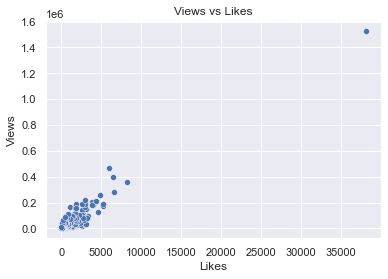

In [62]:
sns.scatterplot(x = 'Likes', y = 'Views', data = df_main).set(title='Views vs Likes')

The initial scatter plot shows a video that got a massive number of views and likes in comparison to most of the other content. In the next section we will create a range more suitable for the sake of making our plot, but will leave the values in our dataset for future reference.

### Distribution Plot <a class="anchor" id="Distribution_Plot"></a>

1584

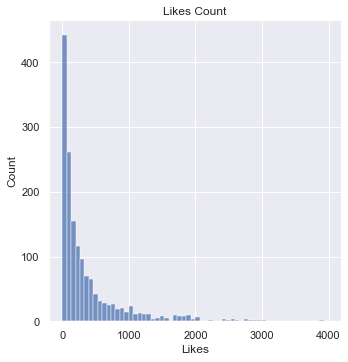

In [64]:
display(df_main.loc[df_main.Likes < 4000].value_counts().sum())
sns.displot(df_main.loc[df_main.Likes < 4000], x = 'Likes').set(title='Likes Count')

If we filter out the number of likes above 4000 we wil be loosing 10 data points from our dataset which is acceptable. We can also see that the majority of the videos recieves under 2000 likes.

### Pair Plot <a class="anchor" id="Pair_Plot"></a>

Text(0.5, 1.01, 'EDA Overview')

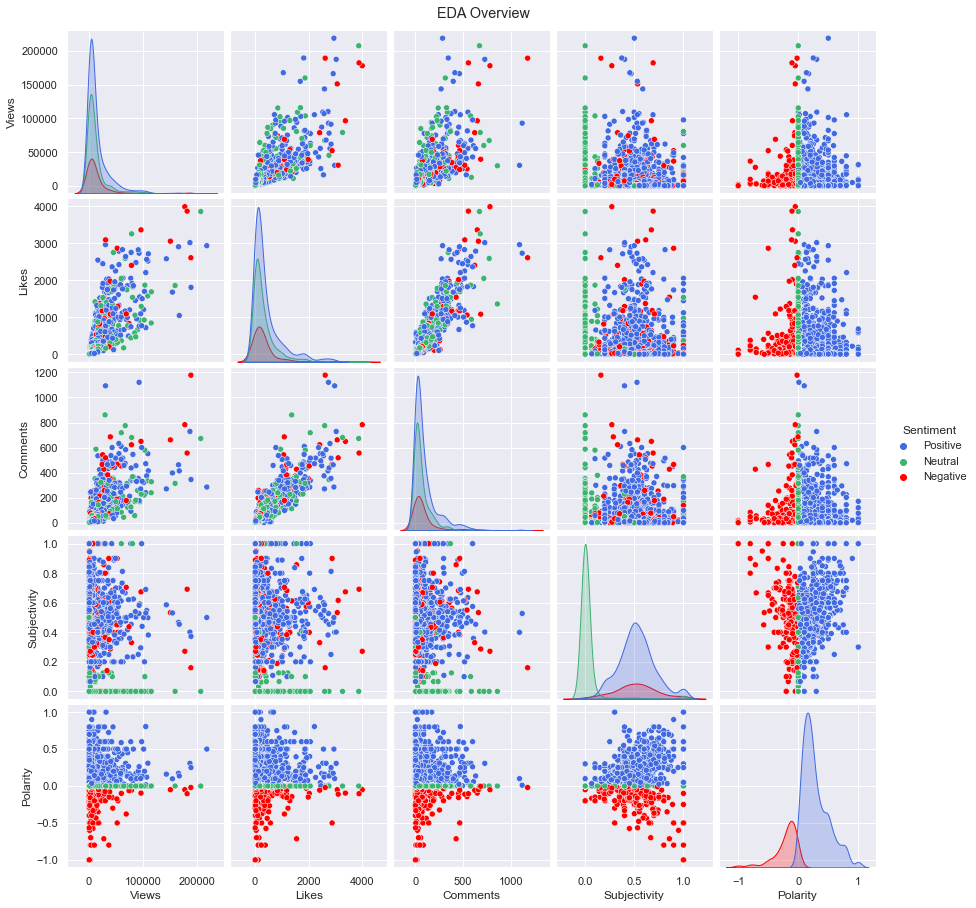

In [93]:
hue_order = ['Positive', 'Neutral', 'Negative']
palette = {'Positive':'royalblue', 'Neutral':'mediumseagreen', 'Negative':'red'}
g = sns.pairplot(df_main.loc[df_main.Likes < 4000], hue ='Sentiment', hue_order = hue_order, palette = palette)
g.fig.suptitle('EDA Overview', y = 1.01)

The pairplot gives the user a good first glance at our data, here we can ask ourselves a plethora of questions. Looking at the Polarity distribution plot it suggests that overall the sentiment for the channel is far more positive than negative. Another interesting result is that the subjectivity plot is showing that positive sentiment is generally more subjective in nature when compared to negative sentiment. In fact, as seen below viewers responding with a either Positive or Negative sentiment are more objective in their reasoning by quite a bit.

In [74]:
print(f'Subjective: {df_main.loc[df_main.Subjectivity > 0.5].value_counts().sum()}')
print(f'Objective: {df_main.loc[df_main.Subjectivity < 0.5].value_counts().sum()}')
print(f'Neutral: {df_main.loc[df_main.Subjectivity == 0.5].value_counts().sum()}')

Subjective: 575
Objective: 970
Neutral: 49


Removing the videos with the top ten most likes cleaned up our graph quite a bit. Comments Vs Likes seems to be showing an apparent linear trend while Comments/Likes Vs Views seems to be less apparent. 

### Linear Regression <a class="anchor" id="Linear_Regression"></a>

Text(0.5, 0.98, 'Linear Regression')

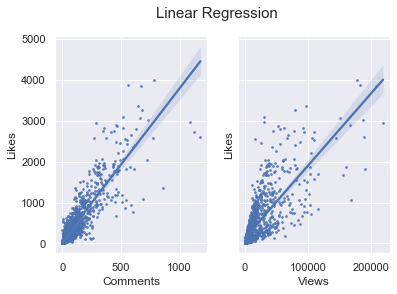

In [87]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.regplot(x='Comments', y='Likes', data= df_main.loc[df_main['Likes'] < 4000], scatter_kws={'s':3}, ax=ax1)
sns.regplot(x='Views', y='Likes', data= df_main.loc[df_main['Likes'] < 4000], scatter_kws={'s':3}, ax=ax2)
fig.suptitle('Linear Regression', fontsize=15)

The linear regression plot with Likes Vs Comments supports the view that if someone is willing to leave a like they may be more likely to leave a comment. The same could possibly be presumed for dislikes. Likes Vs Comments shows proportionality as well if we have more views we are more likely to receive feedback from viewers.

In [88]:
def top10_last10(df):
    
    """
    Function top10_last10 plots the most and least viewed videos.
    
    The top barchart is depicted in millions of views note the 1e6 scientific notation.
        
    Args:
        df (Pandas DataFrame): Dataframe created from Youtube API query
    """
    
    top10_views = df.sort_values(by='Views', ascending=False).head(10)
    least10_views = df.sort_values(by='Views', ascending=False).tail(10)
    fig, axs = plt.subplots(figsize=(11,7),nrows=2)
    sns.set_palette("bright")
    sns.barplot(x="Views", y="Title", data=top10_views, ax=axs[0]).set(title='Top 10 Viewed (M)')
    axs[0].set(xlabel=None)
    axs[0].set(ylabel=None)
    sns.barplot(x="Views", y="Title", data=least10_views, ax=axs[1])
    axs[1].set(xlabel='Least 10 Viewed')
    axs[1].set(ylabel=None)

### Top Ten Plot <a class="anchor" id="Top_Ten_Plot"></a>

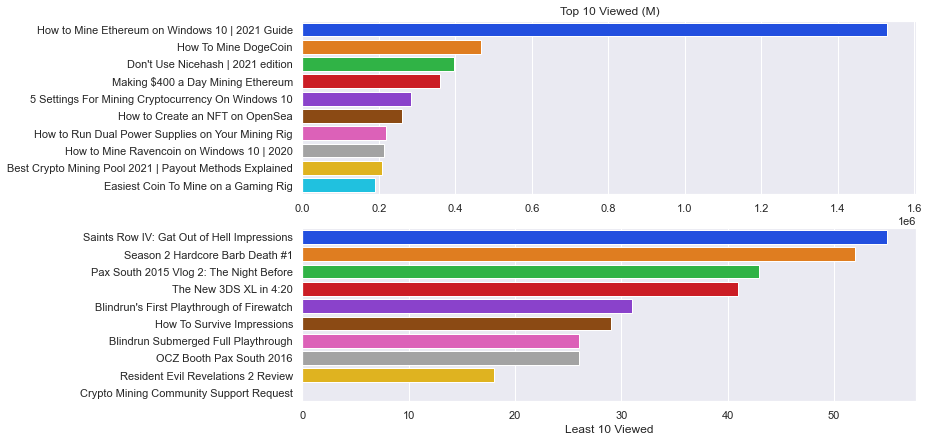

In [89]:
top10_last10(df_main)

The two horizontal bar charts represent the top and bootm ten videos viewed on the channel. Upon inspection are data shows that the most popular videos were crypto related.

In [90]:
def find_string(col_val):
    
    """
    Function find_string finds string matches in a series based on a list of strings to search for.
         
    Args:
        col_val (Pandas Series): Applies the function to the specified column/series
    """
    
    for i in query_string:
        if i.lower() in col_val.lower():
            return i
    else:
        return np.nan   

### Swarm Plot <a class="anchor" id="Swarm_Plot"></a>

Mining    264
Crypto    131
Coin      122
Name: TitleKeyW, dtype: int64

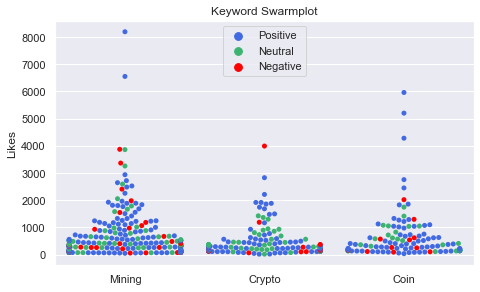

In [228]:
query_string = ['Mining', 'Crypto', 'Coin']
df_main['TitleKeyW'] = df_main['Title'].apply(find_string)

display(df_main['TitleKeyW'].value_counts())
hue_order = ['Positive', 'Neutral', 'Negative']
palette = {'Positive':'royalblue', 'Neutral':'mediumseagreen', 'Negative':'red'}

plt.rcParams["figure.figsize"] = [7.50, 4.5]
sns.swarmplot(x = 'TitleKeyW', y = 'Likes', data = df_main, hue = 'Sentiment', hue_order = hue_order, palette = palette).set(title='Keyword Swarmplot')
plt.xlabel(None)
plt.yticks(np.arange(0, 9000, step=1000));
plt.legend(loc='upper center')

The swarm plot above represents the videos that had the keywords mining, coin, and crypto in the title. These were chosen because of the fact that the topics were noticed in the top ten views that were received. Here we can see that videos with mining in the title received the most likes, followed by coin, and last crypto. Based on the data distribution, the majority of videos with mining in the title received between 800 and 1200 likes. The majority of videos with crypto in the title received between 500 and 900 likes. The majority of videos with coin in the title received between 500 and 1200 likes.

In [214]:
df_main['Month'] = pd.to_datetime(df_main['Published_date']).dt.strftime('%b')
df_main['Day'] = pd.to_datetime(df_main['Published_date']).dt.strftime('%A')
df_main.to_csv('SOT.csv')

### Box Plot <a class="anchor" id="Box_Plot"></a>

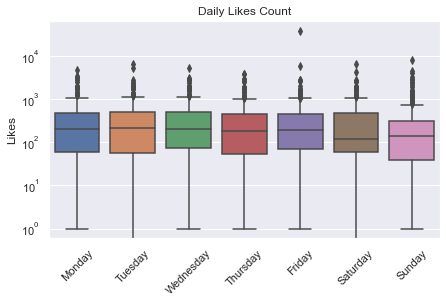

In [253]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
days_type = CategoricalDtype(categories=days, ordered=True)

plt.figure(figsize = (7,4))
ax = sns.boxplot(x ='Day', y ='Likes', data = df_main, order = days)
ax.set_yscale('log')
plt.title('Daily Likes Count')
plt.xlabel(None)
plt.xticks(rotation=45);

The boxplot above represents the likes per day over all the videos. The solid black line represents the median value, the box itself represents the inner quartile range 25%-75%, the whiskers represent the the min/max likes, and the black diamonds represent values outside 1.5*IQR(outliers). The reasoning behind making a boxplot was the fact that there are some videos that received a massive amount of likes on some weekdays compared to that same day the following or previous week. The boxplot along with the log scale on the Y-axis allows for a better visual representation of the data as a whole. What we would be more interested is the average amount of likes per day. According to our data we can see that content published on Friday received the most likes on average, followed by Monday and Tuesday in the ouput below.

In [243]:
df_main['Day'] = df_main['Day'].astype(days_type)
#median_days = df_main.groupby(['Day'])['Likes'].median()
mean_days = df_main.groupby(['Day'])['Likes'].mean()
print(mean_days)

Day
Monday       461.180412
Tuesday      449.161435
Wednesday    414.129310
Thursday     408.969957
Friday       569.880734
Saturday     376.897638
Sunday       384.037344
Name: Likes, dtype: float64


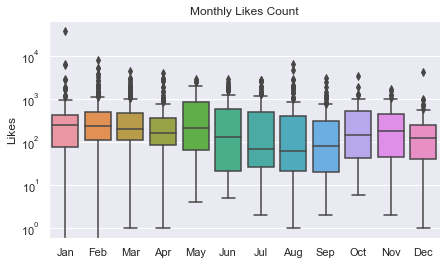

In [255]:
months = ['Jan','Feb','Mar','Apr','May','Jun',
          'Jul','Aug','Sep','Oct','Nov','Dec']
months_type = CategoricalDtype(categories=months, ordered=True)

plt.figure(figsize = (7,4))
ax = sns.boxplot(x ='Month', y ='Likes', data = df_main, order = months)
plt.title('Monthly Likes Count')
plt.xlabel(None)
ax.set_yscale('log');

The same plot has been prepared, but this time on a monthly basis. The mean values have been calculated once again and January has the highest monthly likes and August has the lowest.

In [239]:
df_main['Month'] = df_main['Month'].astype(months_type)
days = df_main.groupby(['Month'])['Likes'].median()
print(days)

Month
Jan    248.0
Feb    233.0
Mar    203.5
Apr    163.0
May    216.5
Jun    130.5
Jul     70.0
Aug     62.0
Sep     82.0
Oct    148.0
Nov    185.0
Dec    127.0
Name: Likes, dtype: float64


## Conclusion <a class="anchor" id="Conclusion"></a>

Our data exploration journey began with querying the Youtube API. It was necessary to first query using the channels resource for the playlist ID
from our channel. From there it was a matter of using the playlistItems resource to retrieve a list of video id's that allowed for the retrieval of comments, replies, and basic statistics for each video. The TextBlob lib was utilized to examine the text in the comments/replies to give an idea as to wether or not the videos topic was well received. 

The EDA showed us some interesting patterns in the data. Viewers of the channel according to the classifications of the comments and replies they left were having conversations that were categorically more objective. The amount of Likes a video received was directly proportional to the views and amount of comments it received. The overall viewer response was by far more positive than negative. The data had one anomalous video "How to Mine Ethereum on Windows 10|2021 Guide" which received a massive amount of views and likes that skewed are data such that it needed to be omitted from some analysis. The keywords mining, coin, and crypto were used to query video titles to evalute the effect they had on likes received. This search showed that videos with mining in the title got the most likes and also gave a quick visual distribution of the number of likes. Boxplots created for the dataset on a daily and monthly basis gave some more insight into the behavior on how likes received varied. The monthly plot was a bit more interesting in this respect. The variance in the distribution of likes during the summer months was greater than during the winter while the mean value was higher during the winter when compared to the summer. This might be explained by the season, more people are inside during the winter, and because of this more regular viewers are not giving as many likes as often hence the variance in the distribution during the summer.

Even with this modest dataset we managed to extract plenty of insight with the few graphs and calculations made. Future changes may be some kind of ML applications, other channel comparisons, external data to enhance what is already here.